In [2]:
#Packages
import warnings
warnings.filterwarnings('ignore')
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from PIL import Image
from pymks import (plot_microstructures, PrimitiveTransformer, TwoPointCorrelation)

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
#Append images all to one list.
images = []
for filename in glob.glob(r'C:\Users\mikep\Desktop\project\data\microstructures_test3\*.tif'):
    im=Image.open(filename)
    images.append(im)
np.shape(images[0])

(989, 989)

In [6]:
#List comprehension to convert the members of the "images" list to arrays.
imarrays = [np.array(x) for x in images]
imarrays[0].shape

(989, 989)

In [7]:
#Stacking all image arrays to create the 'sample' dimension and to convert the list to an array.
data_a = np.stack(imarrays, axis=0)
data_a.shape

(30, 989, 989)

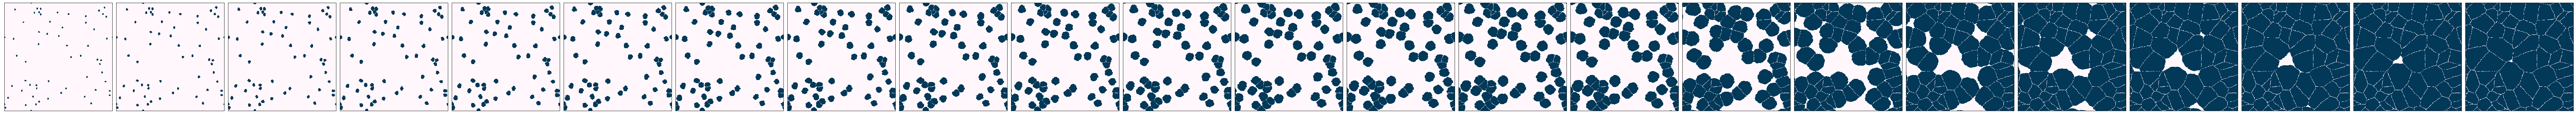

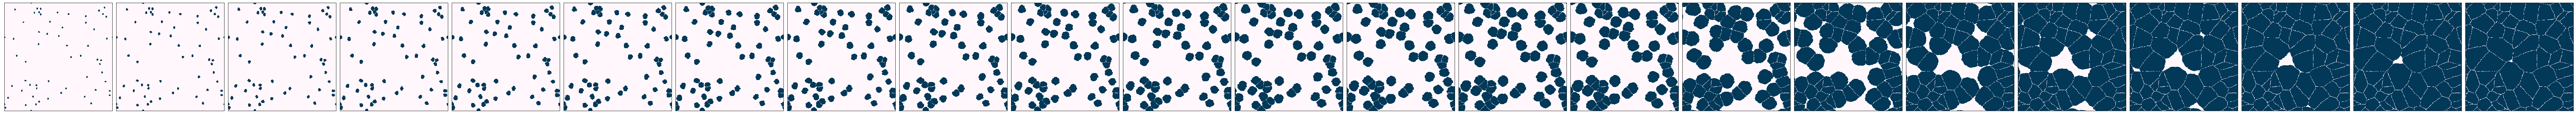

In [8]:
#Visualization of the microstructures.
plot_microstructures(*data_a[7:30], cmap='PuBu', colorbar=False)

In [9]:
#List comprehension to add the "phases" axis with the PrimitiveTransformer class.
data = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_a)
data.shape

(30, 989, 989, 2)

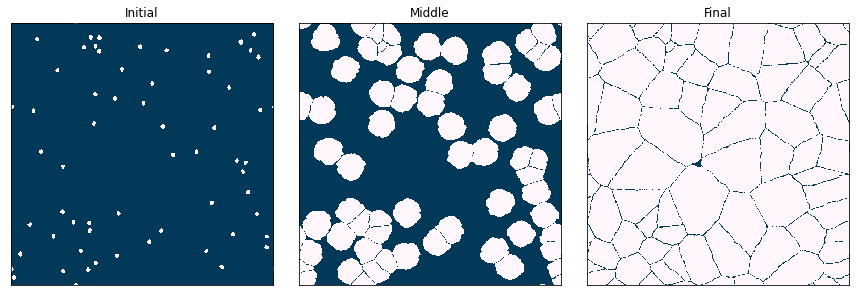

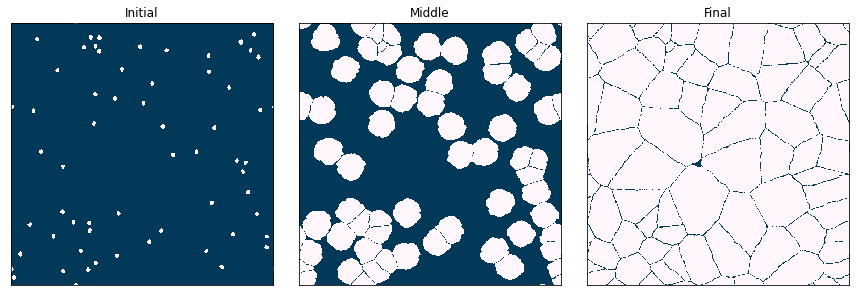

In [10]:
#Initial and final microstructures.
plot_microstructures(data[7, :, :, 0], data[21, :, :, 0], data[29, :, :, 0], titles=['Initial', 'Middle', 'Final'], cmap='PuBu', colorbar=False)

In [11]:
#Calculating two-point statistics.
two_points = TwoPointCorrelation(periodic_boundary=True, cutoff=200, correlations=[(0, 1)]).transform(data)
initial_shape = two_points.shape
print(initial_shape)

(30, 401, 401, 1)


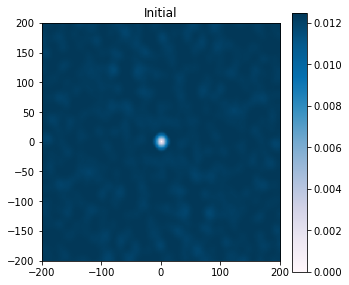

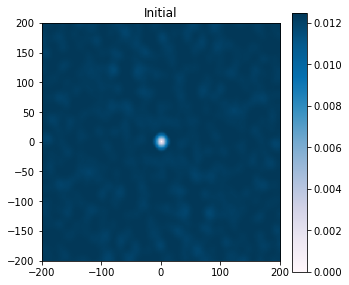

In [12]:
#Initial two-point statistics.
plot_microstructures(two_points[7, :, :, 0], titles=['Initial'], cmap='PuBu', showticks=True)

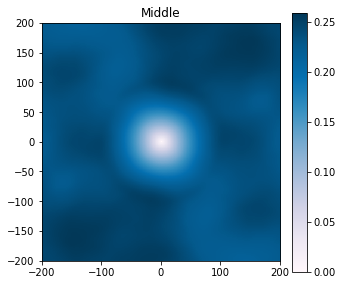

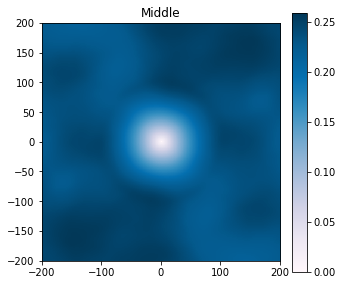

In [13]:
#Middle two-point statistics.
plot_microstructures(two_points[21, :, :, 0], titles=['Middle'], cmap='PuBu', showticks=True)

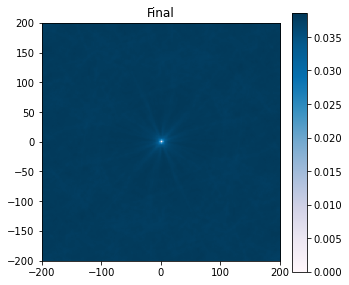

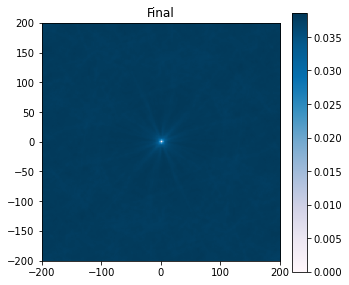

In [14]:
#Final two-point statistics.
plot_microstructures(two_points[29, :, :, 0], titles=['Final'], cmap='PuBu', showticks=True)

In [17]:
#Recrystallized Volume Fraction
center = two_points.shape[1] // 2
print(center)
print('Recrystallized Volume Fraction = ', two_points[18, center, center, 0].compute())

200
Recrystallized Volume Fraction =  8.1833321888957e-18


In [20]:
#Reshape the two-point statistics for the PCA model.
reshaped_two_points=two_points.reshape(30, -1)
reshaped_two_points.shape

(30, 160801)

In [21]:
#PCA
pca = PCA(svd_solver='full', n_components=5)
pc_scores=pca.fit_transform(reshaped_two_points)
pc_scores.shape

(30, 5)

In [22]:
print(pca.components_) 
print(pca.components_.shape)

[[ 0.00244208  0.00244019  0.00243854 ...  0.00243854  0.00244019
   0.00244208]
 [ 0.00104654  0.00104293  0.00103936 ...  0.00103936  0.00104293
   0.00104654]
 [-0.00264097 -0.00266132 -0.00267314 ... -0.00267314 -0.00266132
  -0.00264097]
 [ 0.00061577  0.00068876  0.00078432 ...  0.00078432  0.00068876
   0.00061577]
 [-0.00423675 -0.00420352 -0.004157   ... -0.004157   -0.00420352
  -0.00423675]]
(5, 160801)


In [23]:
#First principal component (PC1). 
pc1, pc2, pc3, pc4, pc5 = np.split(pc_scores, 5, axis=1)
print(pc1.shape)
print(pc1)
##Note: No "axis=1" in order to obtain pc-scores for different microstructure classes.

(30, 1)
[[-36.40361498]
 [-36.30766966]
 [-36.30766966]
 [-35.92842037]
 [-35.86270589]
 [-35.08727906]
 [-34.12411358]
 [-31.49850307]
 [-27.26756524]
 [-21.86879833]
 [-15.11629488]
 [ -7.73674976]
 [  0.15903623]
 [  8.13105132]
 [ 16.32881545]
 [ 24.17329049]
 [ 31.60377443]
 [ 38.45727546]
 [ 44.50694077]
 [ 49.62795632]
 [ 53.64779373]
 [ 56.47194871]
 [ 54.46665571]
 [ 35.16725602]
 [ 14.00852852]
 [ -2.00847313]
 [-11.65715014]
 [-18.02008475]
 [-20.28763986]
 [-21.26759083]]


In [24]:
zeros=np.zeros((30, 4))
reshaped_pc1=np.hstack((pc1,zeros))
print(reshaped_pc1)
print(reshaped_pc1.shape)

[[-36.40361498   0.           0.           0.           0.        ]
 [-36.30766966   0.           0.           0.           0.        ]
 [-36.30766966   0.           0.           0.           0.        ]
 [-35.92842037   0.           0.           0.           0.        ]
 [-35.86270589   0.           0.           0.           0.        ]
 [-35.08727906   0.           0.           0.           0.        ]
 [-34.12411358   0.           0.           0.           0.        ]
 [-31.49850307   0.           0.           0.           0.        ]
 [-27.26756524   0.           0.           0.           0.        ]
 [-21.86879833   0.           0.           0.           0.        ]
 [-15.11629488   0.           0.           0.           0.        ]
 [ -7.73674976   0.           0.           0.           0.        ]
 [  0.15903623   0.           0.           0.           0.        ]
 [  8.13105132   0.           0.           0.           0.        ]
 [ 16.32881545   0.           0.           0.   

In [25]:
#Explained variance by each principal component.
exp_var_pca=pca.explained_variance_ratio_
cum_sum=np.cumsum(pca.explained_variance_ratio_)
print(exp_var_pca)
print(cum_sum)

[9.95667128e-01 3.46630087e-03 6.15547457e-04 1.07887330e-04
 7.79138963e-05]
[0.99566713 0.99913343 0.99974898 0.99985686 0.99993478]


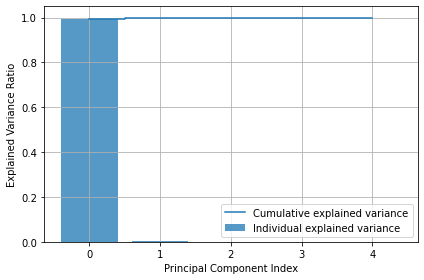

In [26]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.75, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

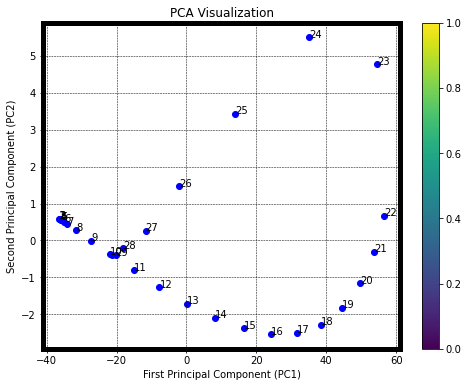

In [31]:
#Principal component analysis visualization.
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.scatter(pc_scores[:,0], pc_scores[:,1], c='b', marker='o') 
ax.set_xlabel("First Principal Component (PC1)")
ax.set_ylabel("Second Principal Component (PC2)")
ax.set_title("PCA Visualization")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('5')  
n = range(1,30)
for i, txt in enumerate(n):
    plt.annotate(txt, (pc_scores[i,0], pc_scores[i,1]))
plt.colorbar()
plt.show()

In [32]:
#Inverting and reshaping the data.
two_points_inv_pc = pca.inverse_transform(pc_scores)
two_points_inv_pc1 = pca.inverse_transform(reshaped_pc1)
recovered_two_points_pc = np.reshape(two_points_inv_pc,initial_shape)
recovered_two_points_pc1 = np.reshape(two_points_inv_pc1,initial_shape)
print(two_points_inv_pc.shape)
print(recovered_two_points_pc.shape)
print(recovered_two_points_pc)

(30, 160801)
(30, 401, 401, 1)
[[[[-7.72930714e-05]
   [-7.65482232e-05]
   [-7.32778141e-05]
   ...
   [ 1.58477245e-04]
   [ 1.56820359e-04]
   [ 1.57558524e-04]]

  [[-7.83719395e-05]
   [-7.62185190e-05]
   [-7.32984003e-05]
   ...
   [ 1.52280606e-04]
   [ 1.50089449e-04]
   [ 1.51171462e-04]]

  [[-7.81392960e-05]
   [-7.58572736e-05]
   [-7.44429885e-05]
   ...
   [ 1.44527001e-04]
   [ 1.41755771e-04]
   [ 1.43024945e-04]]

  ...

  [[ 1.43024945e-04]
   [ 1.41755771e-04]
   [ 1.44527001e-04]
   ...
   [-7.44429885e-05]
   [-7.58572736e-05]
   [-7.81392960e-05]]

  [[ 1.51171462e-04]
   [ 1.50089449e-04]
   [ 1.52280606e-04]
   ...
   [-7.32984003e-05]
   [-7.62185190e-05]
   [-7.83719395e-05]]

  [[ 1.57558524e-04]
   [ 1.56820359e-04]
   [ 1.58477245e-04]
   ...
   [-7.32778141e-05]
   [-7.65482232e-05]
   [-7.72930720e-05]]]


 [[[ 1.71593563e-04]
   [ 1.71949194e-04]
   [ 1.74651353e-04]
   ...
   [ 3.94230765e-04]
   [ 3.92688560e-04]
   [ 3.93363516e-04]]

  [[ 1.70486145

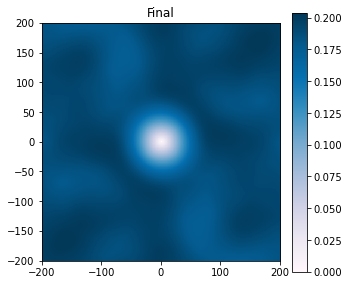

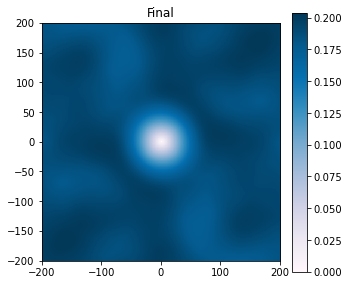

In [38]:
#Recovered two-point statistics using both PC scores. 
plot_microstructures(recovered_two_points_pc[17, :, :, 0], titles=['Final'], cmap='PuBu', showticks=True)

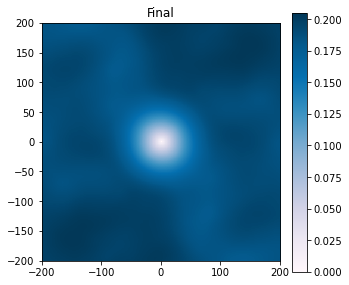

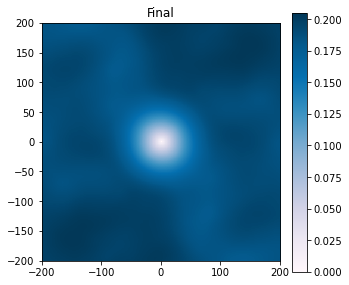

In [39]:
#Recovered first two-point statistics using only PC1. recovered_two_points_pc1[0, :, :, 0], 
plot_microstructures(recovered_two_points_pc1[17, :, :, 0], titles=['Final'], cmap='PuBu', showticks=True)

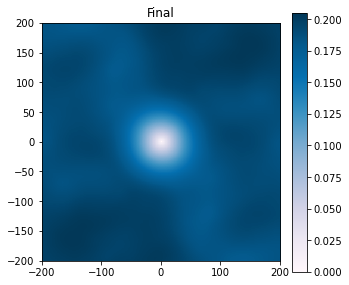

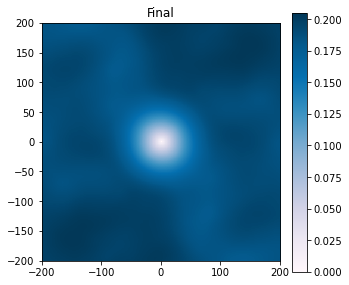

In [40]:
#Recovered final two-point statistics using only PC1. recovered_two_points_pc1[0, :, :, 0], 
plot_microstructures(recovered_two_points_pc1[17, :, :, 0], titles=['Final'], cmap='PuBu', showticks=True)

In [41]:
#Save the pc scores.
df1 = pd.DataFrame(pc1)
df1.to_csv(r'C:\Users\mikep\Desktop\project\data\pc_scores\pc1_micress.csv')

In [45]:
zeros2=np.zeros((30, 5))
zeros2[(0,0)]=-36.40361498
print(zeros2)

[[-36.40361498   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.   

In [46]:
two_points_inv_pcnew = pca.inverse_transform(zeros2)
print(two_points_inv_pcnew.shape)

(30, 160801)


In [47]:
recovered_two_points = np.reshape(two_points_inv_pcnew, initial_shape)
print(recovered_two_points.shape)

(30, 401, 401, 1)


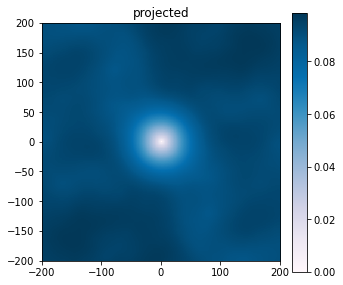

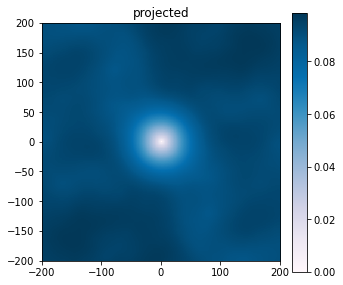

In [49]:
plot_microstructures(recovered_two_points[17, :, :, 0], titles=['projected'], cmap='PuBu', showticks=True)